In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
import matplotlib.animation as animation
from pylab import *
from sklearn.utils import shuffle

### Dataset generation

In [3]:
def division_formula(x, mean, cov):
    res = ((x - mean).T).dot(np.linalg.inv(cov)).dot((x - mean).T)
    return res
    
def get_class_idxs(idx, needed_points_amount):
    random_indices = np.random.choice(idx, size=needed_points_amount, replace=True)
    return random_indices


def generate_sample(mean, cov, points_class1 = 1000, points_class2 = 1000, d_coef = 0.1, eps_coef = 0.1):
    #generate random normal points
    normal_points = np.random.multivariate_normal(mean, cov, 10*points_class1)
    result_array = []
    for i in normal_points:
        result_array.append(division_formula(i, mean, cov))
    #select random 1000 points of class1
    class1_idx = np.concatenate(np.argwhere(result_array >= ((sum(cov.diagonal()) * d_coef)*(1+eps_coef))))
    class1_idx = get_class_idxs(class1_idx , points_class1)
    X1 = normal_points[class1_idx, :]  
    #select random 1000 points of class2
    class2_idx = np.concatenate(np.argwhere(result_array <= (sum(cov.diagonal()) * d_coef*(1-eps_coef))))
    class2_idx = get_class_idxs(class2_idx , points_class1)
    X2 = normal_points[class2_idx, :]
    
    return X1, X2

In [4]:
def create_dataframe(sample1, sample2): 
    columns_names = ['x{}'.format(i) for i in range(sample1.shape[1])]
    df1 = pd.DataFrame(sample1, columns = [*columns_names])
    df1['target'] = 0
    df2 = pd.DataFrame(sample2, columns = [*columns_names])
    df2['target'] = 1
    return  df1.append(df2)
    
def data_shuffle(data):
    data_shuffled = shuffle(data, random_state=42)
    X = data_shuffled.drop('target', 1)
    y = data_shuffled['target']
    return data_shuffled, X, y

### Model definition

In [23]:
class Perceptron():

    def __init__(self):
        """
        Constructs class instance
        :param n_iter: number of the iterations
        """
    
        self.n_iter = 0
        self.alpha = 0
        
        
    @staticmethod
    def vectors_transformation(vector):
        """
        Transforms vector (ksi) to appropriate form according to specific rule
        :param vector: vector to be transformed
        :return: transformed vector
        """
        
        vector_ = np.einsum('i,j->ij', vector, vector).ravel()
        vector_ = np.concatenate((vector_, vector, [1]))
        return vector_
    
    
    @staticmethod
    def eig_vector_transformation(vector):
        """
        Transforms eigen vector (eta) to appropriate form according to specific rule
        :param vector: vector to be transformed
        :return: transformed vector
        """
        
        vector_ = np.einsum('i,j->ij', vector, vector).ravel()
        vector_ = np.concatenate((vector_, np.zeros(len(vector)+1)))
        return vector_

    
    def check_eig(self, alpha):
        """
        Finds eigen vectors and their transformed versions. Also finds a product between alphas and transformed eigen vectors
        :param alpha: transformed vector from initial properties
        :param dim: dimension of the X
        :return: array with products of alphas and transformed eigen vectors, array with transformed eigen vectors
        """
        
        A = np.reshape(self.alpha[:self.dim**2], newshape=(self.dim, self.dim))
        v, l = np.linalg.eigh(A)
        l_all = [l[:, i] for i in range(len(l))]
        eta_l = [self.eig_vector_transformation(l_all[i]) for i in range(len(l))]
        return eta_l, v

    
    def fit(self, X, y):
        """
        Training process
        :param X: array with x values to be trained on
        :param y: array with target classes
        """
        
        self.dim = X.shape[1]
        self.alpha = np.zeros(self.dim**2+self.dim+1)
        correction_isneeded = True
        while (correction_isneeded):
            self.n_iter +=1
            correction_isneeded = False
            for xi, target in zip(X, y):
                ksi_i = self.vectors_transformation(xi)
                alpha_ksi = np.dot(ksi_i,self.alpha)
                if alpha_ksi >= 0 and target == 1:
                    correction_isneeded = True
                    self.alpha -= ksi_i
                elif alpha_ksi <= 0 and target == 0:
                    correction_isneeded = True
                    self.alpha += ksi_i
            if not correction_isneeded:            
                eta_l, eig_vals = self.check_eig(self.alpha)
                for i in range(len(eig_vals)):
                    if eig_vals[i] <= 0:
                        self.alpha = self.alpha + eta_l[i]
                        correction_isneeded = True
                        break
                        
                        
    def alpha_multiply(self, X):
        """
        Finds product between alpha and X
        :param X: array with x values
        :return: array with values corresponded to product between alpha and X
        """
        
        return np.dot(X, self.alpha)

    
    def predict(self, X):
        """
        Function to predict target values
        :param X: array with x values to predict on
        :return: array with predicted target values
        """
        
        ksi_pred = np.zeros((X.shape[0], X.shape[1]**2+X.shape[1]+1))
        k = 0
        for xi in X:
            ksi_pred_i = self.vectors_transformation(xi)
            ksi_pred[k] = ksi_pred_i
            k += 1
        return np.where(self.alpha_multiply(ksi_pred) >= 0.0, 0, 1)
    
    
    def animate(self, X, y, filename='demo.mp4'):
        """
        Animate predictions for every change of alpha (500 iterations)
        :param X: array with x values to be trained on
        :param y: array with target classes
        """
        
        if X.shape[1] != 3:
            raise Exception(f'Dimention of elements of X should be 3, got {X.shape[1]}!')
        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('auto')
        
        graph1, = ax.plot(X[:,0], X[:,1], X[:,2], linestyle="", marker="o", color='yellow')
        graph2, = ax.plot(X[:,0], X[:,1], X[:,2], linestyle="", marker="o", color='yellow')
        
        self.dim = X.shape[1]
        self.alpha = np.zeros(self.dim**2+self.dim+1)

        def update_graph(i):
            self.n_iter +=1
            X_t = X[:self.n_iter, :]
            y_t = y[:self.n_iter]
            for xi, target in zip(X_t, y_t):
                ksi_i = self.vectors_transformation(xi)
                alpha_ksi = np.dot(ksi_i,self.alpha)
                if alpha_ksi >= 0 and target == 1:
                    correction_isneeded = True
                    self.alpha -= ksi_i
                elif alpha_ksi <= 0 and target == 0:
                    correction_isneeded = True
                    self.alpha += ksi_i
            Y_pred = self.predict(X)
            if np.argwhere(Y_pred == 0).any(): 
                X1 = X[np.concatenate(np.argwhere(Y_pred == 0))]
            else:
                X1 = X
            if np.argwhere(Y_pred == 1).any():
                X2 = X[np.concatenate(np.argwhere(Y_pred == 1))]
            else:
                X2 = X
            graph1.set_data(X1[:,0], X1[:,1])
            graph1.set_3d_properties(X1[:,2])
            graph2.set_data(X2[:,0], X2[:,1])
            graph2.set_3d_properties(X2[:,2])
            graph2.set_color('blue')
           
            return graph1, graph2,

        ani = animation.FuncAnimation(fig, update_graph, cache_frame_data = False,
                                      frames = 500, repeat_delay = 50, interval=200)
        writer = animation.writers['ffmpeg'](fps=10.0)
        print('saving may take some time')
        ani.save(filename, writer=writer, dpi=100)

### create dataset

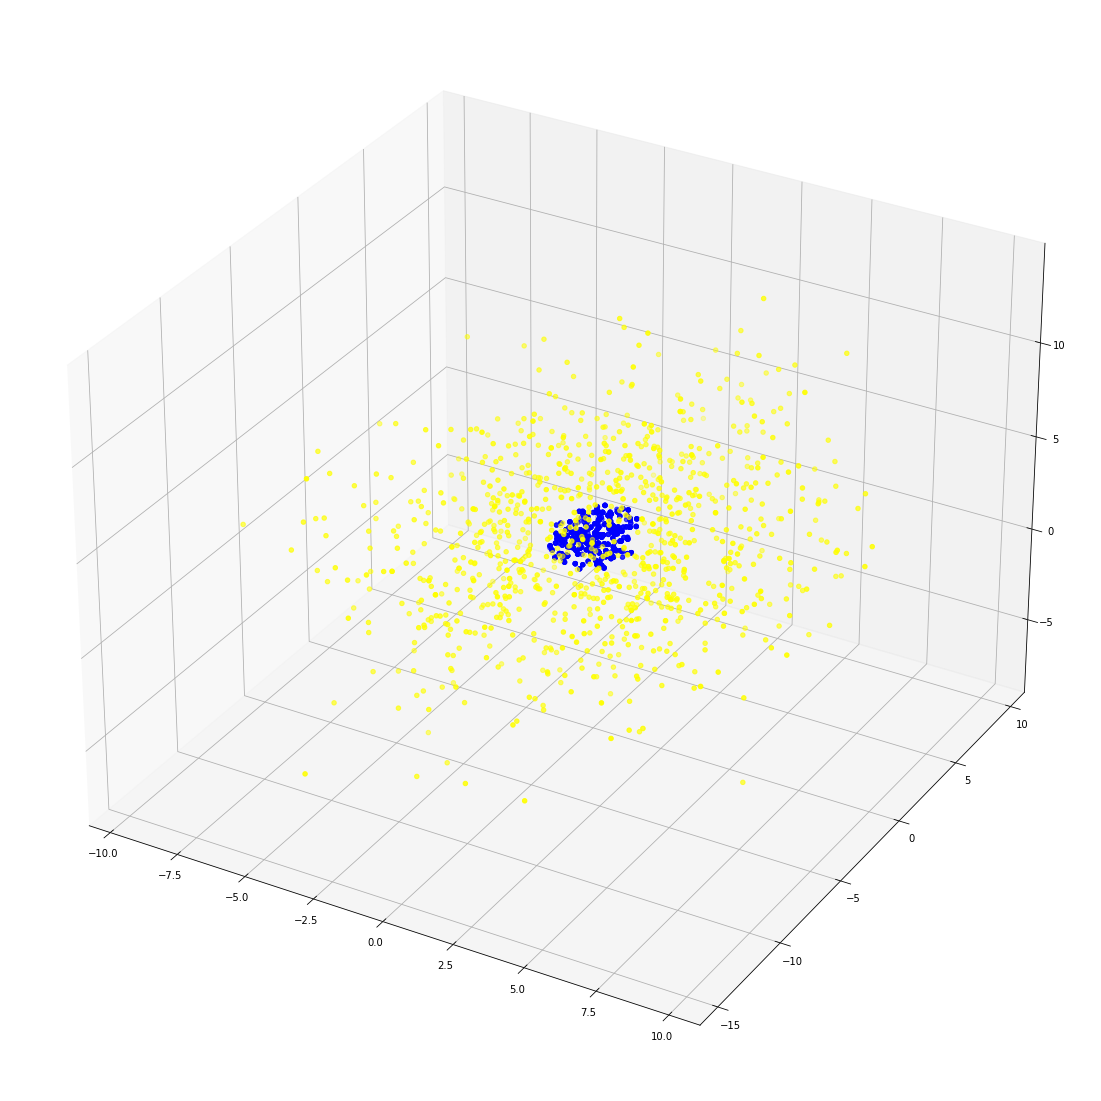

In [26]:
#declare params
mean = np.array([1,-2,3])

cov= np.array([[10,4,1],
       [4, 12, 3],
       [1, 3, 10]])

coef_for_d= 0.01
coef_for_epsilon = 0.4
number_of_points=1000



X1, X2 = generate_sample(mean, cov, d_coef=coef_for_d, eps_coef=coef_for_epsilon)

fig = plt.figure(figsize=((20,20)))
ax= fig.add_subplot(111, projection='3d')
ax.scatter3D(X1[:,0], X1[:,1], X1[:,2], color='yellow' );
ax.scatter3D(X2[:,0], X2[:,1], X2[:,2], color='blue');
plt.show()

In [27]:
df = create_dataframe(X1, X2)
df_shuffle, X, y = data_shuffle(df)
X_new = X.values
y_new = y.values
df_shuffle

,x0,x1,x2,target
860,1.266338,-1.315561,3.380448,1
353,2.842585,0.304977,4.472734,0
333,0.229750,-1.861893,2.521096,1
905,6.364853,6.032256,10.443207,0
289,1.390381,-2.903168,2.476620,1
...,...,...,...,...
130,1.354126,-0.628671,2.915301,1
294,1.512175,-1.852822,3.436088,1
860,2.991227,1.106498,6.895677,0
459,2.062400,-1.863579,3.300108,1


### model train and inference

In [28]:
def find_dist_params(model):
    Sigma_inv = np.reshape(model.alpha[:model.dim**2], newshape=(model.dim, model.dim))
    B = np.array([b/(-2) for b in model.alpha[model.dim**2:model.dim**2+model.dim]])
    mu = np.linalg.solve(Sigma_inv, B)
    return mu, np.linalg.inv(Sigma_inv)


clasifier = Perceptron()
clasifier.fit(X_new, y_new)
prediction = clasifier.predict(X_new)

print(f'accuracy of the classifier:  {accuracy_score(prediction, y_new)}')
mean_pred, cov_pred = find_dist_params(clasifier)
print(f'\nmean predicted: {mean_pred}')
print(f'\ncov predicted:\n {cov_pred}')
print(f'\nclasifier steps:    {clasifier.n_iter}')

accuracy of the classifier:  1.0

mean predicted: [ 1.01038628 -1.75921726  2.71243865]

cov predicted:
 [[0.0068689  0.00320485 0.0012301 ]
 [0.00320485 0.0089188  0.00073325]
 [0.0012301  0.00073325 0.00719165]]

clasifier steps:    1424


### Create an animation of classification 

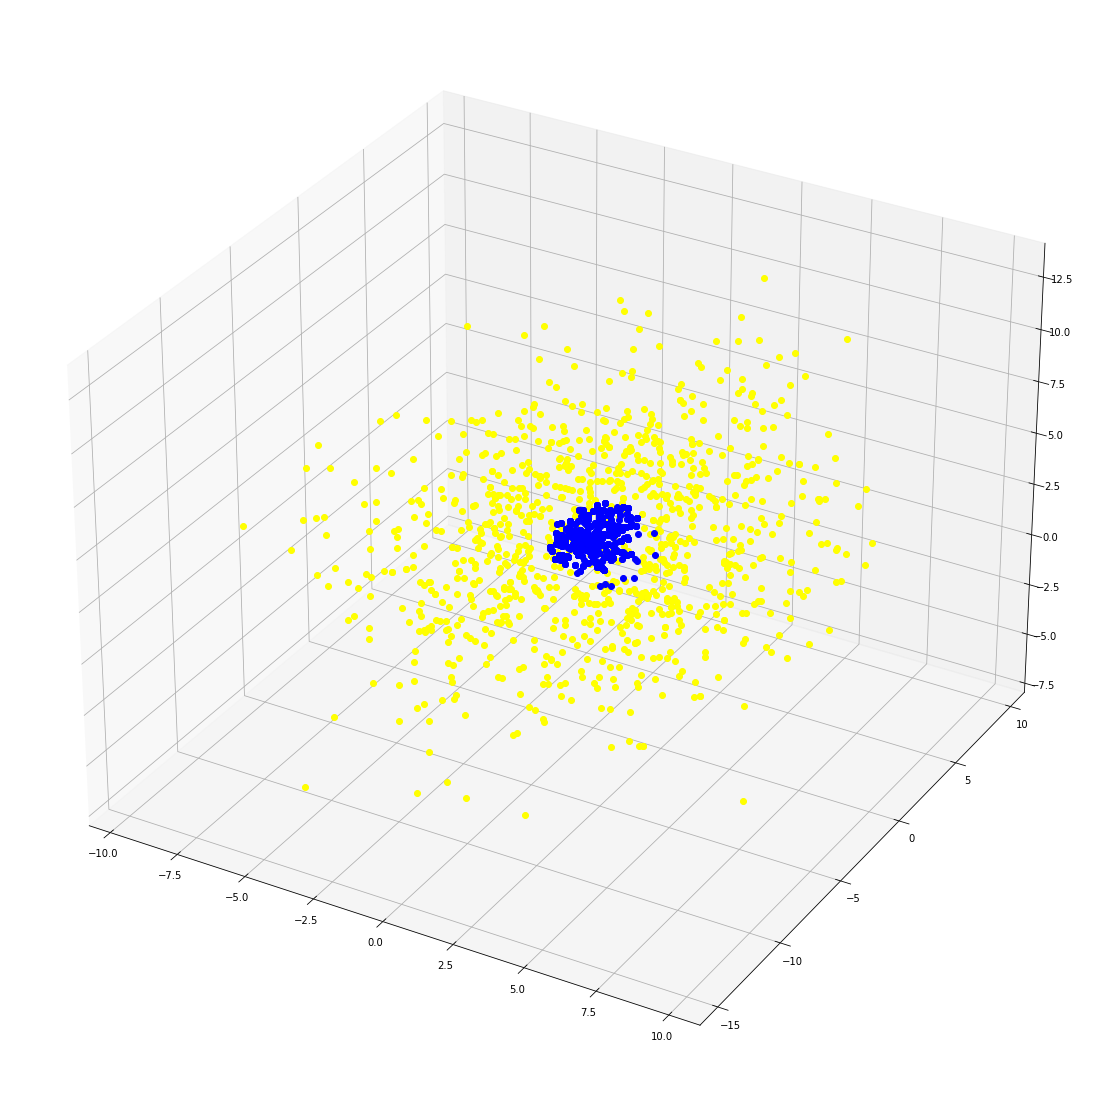

In [29]:
#save a movie as "demo.mp4"
clasifier = Perceptron()
clasifier.animate(X_new, y_new, filename='demo.mp4')